# **The Needed Libraries**



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score

# **Data Preparation (Cifar-10) / Using TensorFlow**

In [ ]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


# **One-hot encode labels**

In [ ]:
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# **Split training data into train + validation (45k train, 5k validation)**

In [ ]:
val_split = int(0.1 * x_train.shape[0])
x_val = x_train[:val_split]
y_val = y_train[:val_split]
x_train = x_train[val_split:]
y_train = y_train[val_split:]

print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)

Training data shape: (45000, 32, 32, 3)
Validation data shape: (5000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


# **Building the Model**

In [ ]:
def build_model():
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(32, 32, 3)),

        # Data Augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),

        # Block 1
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.35),

        # Fully Connected Head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model()

# **Compile the Model**

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,362,698 (9.01 MB)

 Trainable params: 2,361,418 (9.01 MB)

 Non-trainable params: 1,280 (5.00 KB)

# **Setting Up Callbacks (Optional but Recommended)**

In [ ]:
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
    ModelCheckpoint(filepath='best_cifar10_model.h5', save_best_only=True)
]

# **Train the Model**

In [ ]:
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8020 - loss: 0.5699 - val_accuracy: 0.7498 - val_loss: 0.7766 - learning_rate: 5.0000e-04
Epoch 2/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8088 - loss: 0.5528

704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8088 - loss: 0.5528 - val_accuracy: 0.8372 - val_loss: 0.4617 - learning_rate: 5.0000e-04
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8098 - loss: 0.5511 - val_accuracy: 0.8352 - val_loss: 0.4742 - learning_rate: 5.0000e-04
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8139 - loss: 0.5354 - val_accuracy: 0.8350 - val_loss: 0.4989 - learning_rate: 5.0000e-04
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8180 - loss: 0.5268 - val_accuracy: 0.8230 - val_loss: 0.5147 - learning_rate: 5.0000e-04
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8230 - loss: 0.5096 - val_accuracy: 0.8402 - val_loss: 0.4651 - learning_rate: 2.5000e-04
Epoch 7/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8302 - loss: 0.4913

704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8302 - loss: 0.4913 - val_accuracy: 0.8456 - val_loss: 0.4412 - learning_rate: 2.5000e-04
Epoch 8/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8276 - loss: 0.4922

704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8276 - loss: 0.4922 - val_accuracy: 0.8462 - val_loss: 0.4311 - learning_rate: 2.5000e-04
Epoch 9/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8303 - loss: 0.4950 - val_accuracy: 0.8318 - val_loss: 0.4824 - learning_rate: 2.5000e-04
Epoch 10/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8305 - loss: 0.4876 - val_accuracy: 0.8480 - val_loss: 0.4359 - learning_rate: 2.5000e-04
Epoch 11/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8324 - loss: 0.4765 - val_accuracy: 0.8388 - val_loss: 0.4647 - learning_rate: 2.5000e-04
Epoch 12/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8332 - loss: 0.4832 - val_accuracy: 0.8510 - val_loss: 0.4335 - learning_rate: 1.2500e-04
Epoch 13/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8429 - loss: 0.4593 - val_accuracy: 0.8414 - val_loss: 0.4526 - learning_rate: 1.2500e-04
Epoch 14/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - ac

704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8441 - loss: 0.4497 - val_accuracy: 0.8524 - val_loss: 0.4275 - learning_rate: 3.1250e-05
Epoch 19/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8425 - loss: 0.4520 - val_accuracy: 0.8502 - val_loss: 0.4304 - learning_rate: 3.1250e-05
Epoch 20/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8456 - loss: 0.4518 - val_accuracy: 0.8506 - val_loss: 0.4324 - learning_rate: 3.1250e-05
Epoch 21/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8440 - loss: 0.4502 - val_accuracy: 0.8508 - val_loss: 0.4329 - learning_rate: 3.1250e-05
Epoch 22/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8466 - loss: 0.4471 - val_accuracy: 0.8504 - val_loss: 0.4340 - learning_rate: 1.5625e-05
Epoch 23/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8480 - loss: 0.4420 - val_accuracy: 0.8496 - val_loss: 0.4320 - learning_rate: 1.5625e-05
Epoch 24/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - a

704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8445 - loss: 0.4427 - val_accuracy: 0.8514 - val_loss: 0.4271 - learning_rate: 7.8125e-06
Epoch 27/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8451 - loss: 0.4462 - val_accuracy: 0.8514 - val_loss: 0.4291 - learning_rate: 7.8125e-06
Epoch 28/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8412 - loss: 0.4504 - val_accuracy: 0.8506 - val_loss: 0.4307 - learning_rate: 7.8125e-06
Epoch 29/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8464 - loss: 0.4441 - val_accuracy: 0.8498 - val_loss: 0.4297 - learning_rate: 7.8125e-06
Epoch 30/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8443 - loss: 0.4483 - val_accuracy: 0.8506 - val_loss: 0.4311 - learning_rate: 3.9063e-06


# **Save the Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define path in Google Drive
model.save("/content/drive/MyDrive/deeplearning/SavedModels/cifar10_model.h5")
print("Model saved to Google Drive.")

Mounted at /content/drive
Model saved to Google Drive.


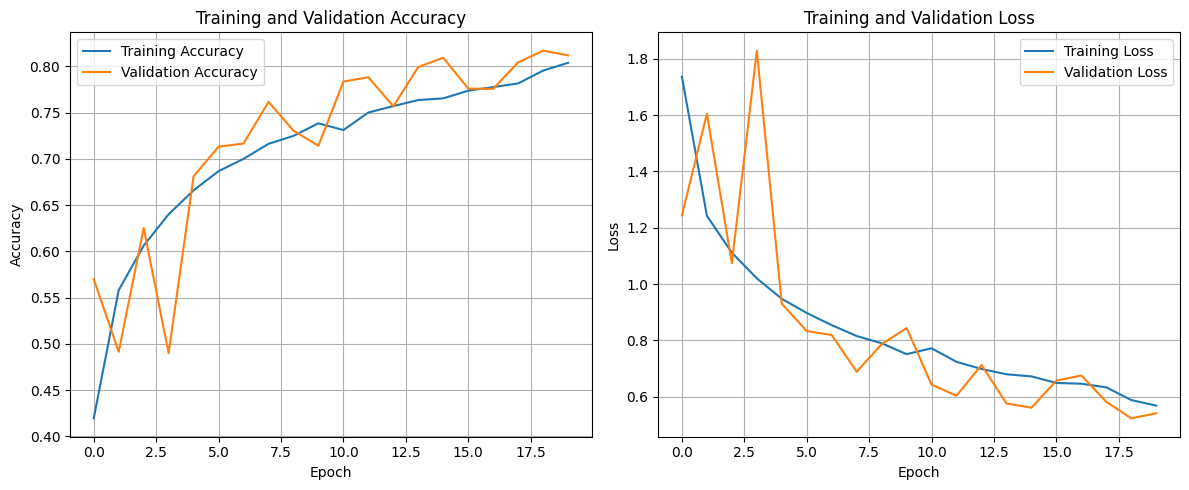

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

# Replace with your actual model path
model_path = '/content/drive/MyDrive/deeplearning/SavedModels/cifar10_model.h5'

# Load the model
loaded_model = load_model(model_path)


Mounted at /content/drive


# **Exploratory Data Analysis (Befor Training)**


1.   Sample Images from Each Class
2.   Class Distribution (Bar Chart)
3.   Image Grid of Augmented Versions
4.   Color Histograms for Each Channel (R, G, B)
5.   Edge Detection / Sobel Filtered Samples



**Sample Images from Each Class**

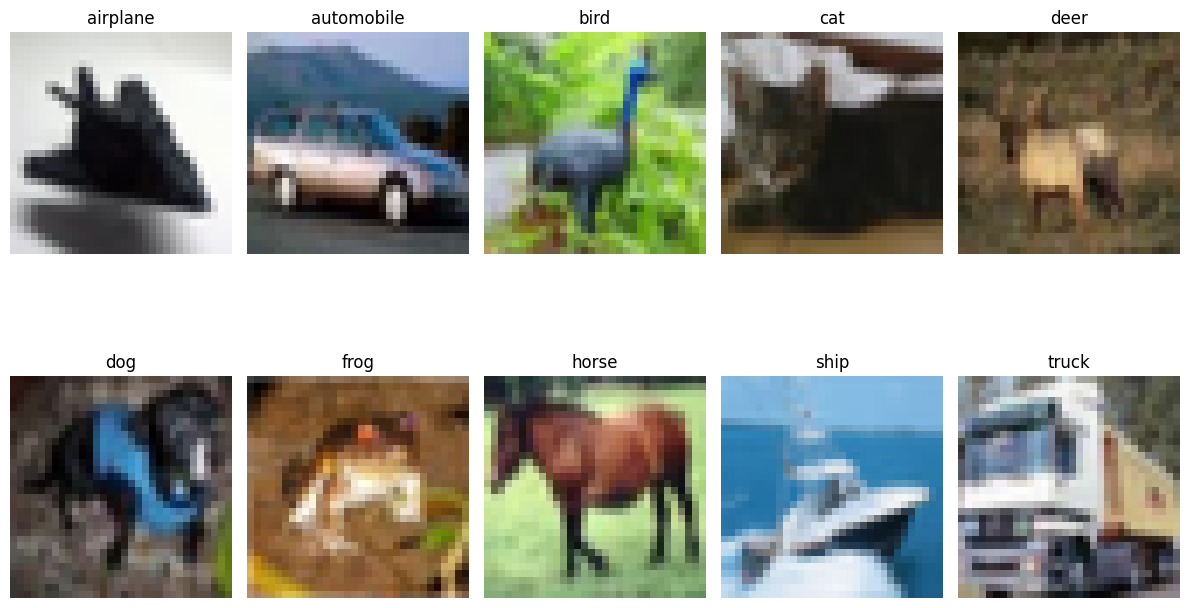

In [ ]:
# Class names in order (CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure to display one image per class
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names):
    # Find the first image of this class
    idx = (y_train == i).squeeze()
    image = x_train[idx][0]  # Get first image of class i

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Class Distribution (Bar Chart)**

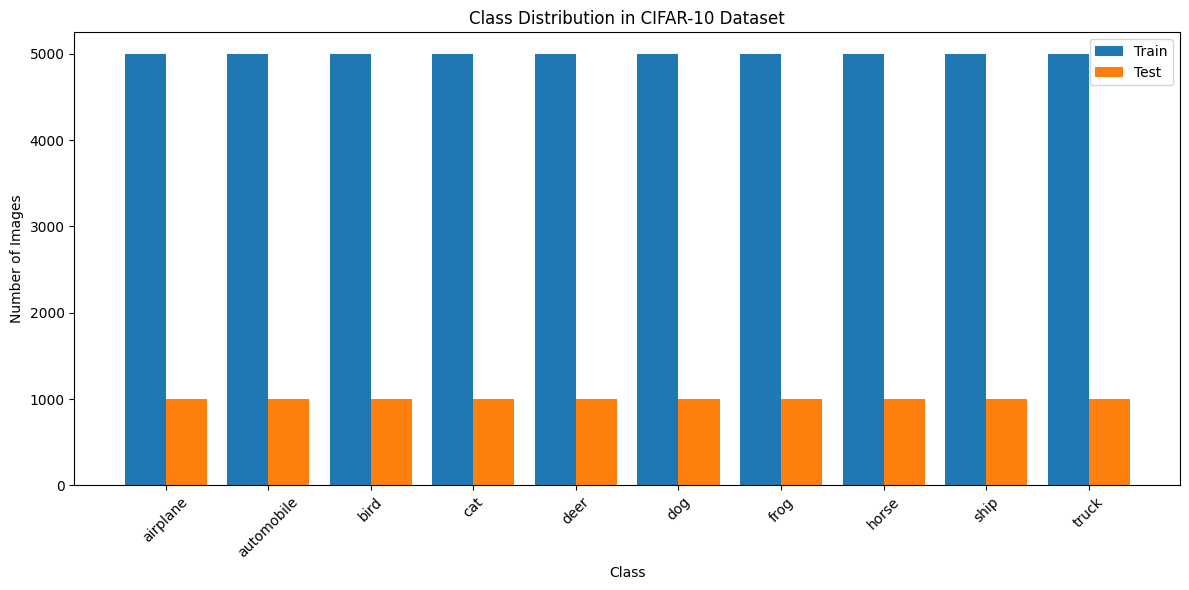

In [ ]:
# Flatten the labels
y_train = y_train.flatten()
y_test = y_test.flatten()

# Get the number of samples per class
class_counts_train = np.bincount(y_train)
class_counts_test = np.bincount(y_test)

# Plot
x_indices = np.arange(len(class_names))

plt.figure(figsize=(12, 6))
plt.bar(x_indices - 0.2, class_counts_train, width=0.4, label='Train')
plt.bar(x_indices + 0.2, class_counts_test, width=0.4, label='Test')

plt.xticks(x_indices, class_names, rotation=45)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in CIFAR-10 Dataset')
plt.legend()
plt.tight_layout()
plt.show()

**Seeing original vs. augmented images side-by-side**

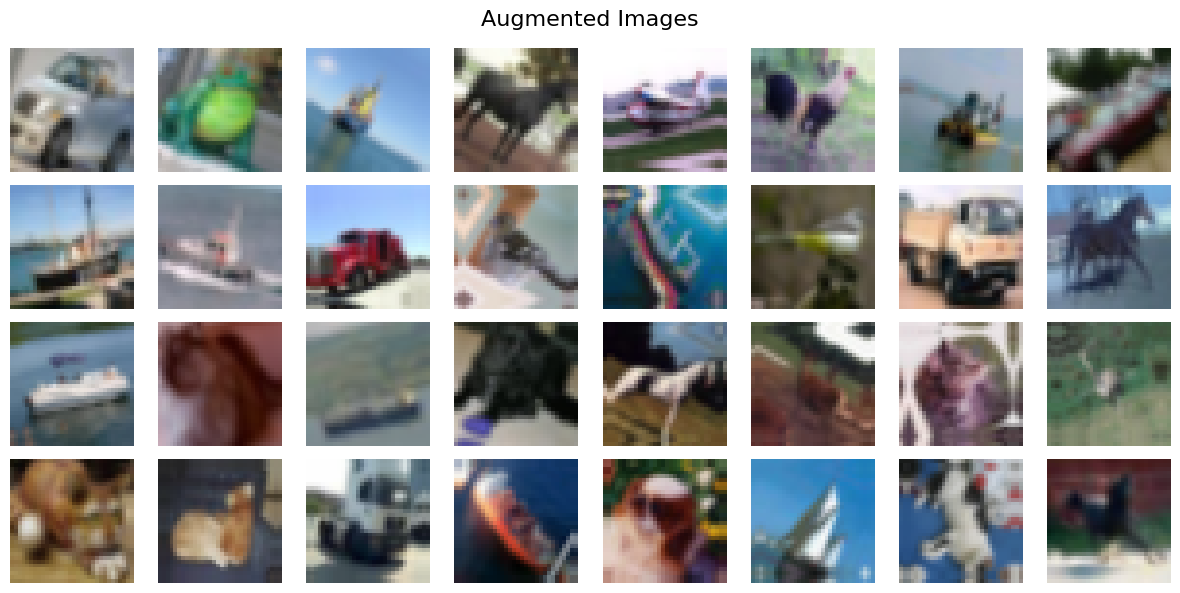

In [ ]:
# Load CIFAR-10 (only training images for visualization)
(x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0

# Convert to a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))

# Define your augmentation pipeline
augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# Function to apply augmentation
def augment_image(image):
    return augmentation(image)

# Apply augmentation in batched mode
batch_size = 64
augmented_dataset = train_dataset.shuffle(1000).map(augment_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

# Get one batch of augmented images
for augmented_images in augmented_dataset.take(1):
    break

# Function to plot images in a grid
def plot_augmented_images(images, n_cols=8, n_rows=4):
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    for i in range(n_cols * n_rows):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle("Augmented Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot the augmented images
plot_augmented_images(augmented_images.numpy())

**Image Grid of Augmented Versions**


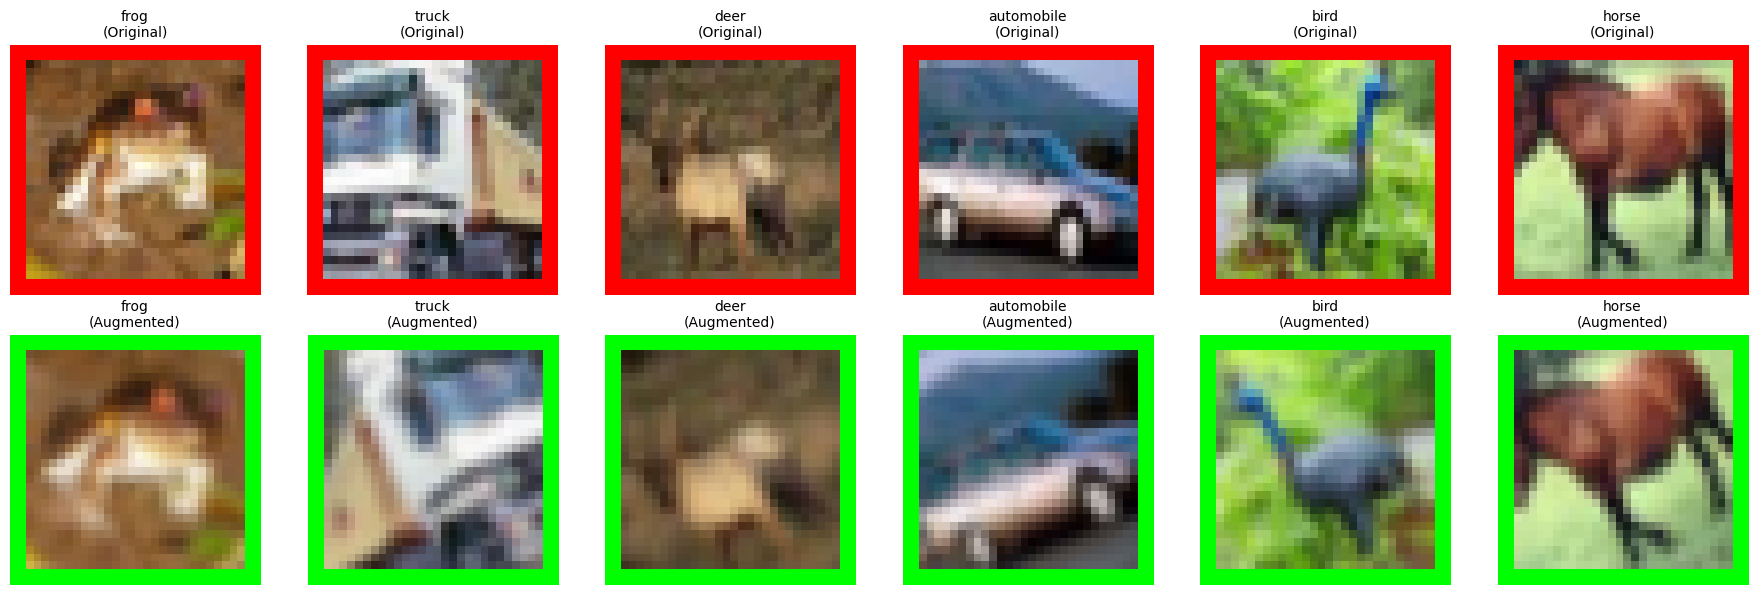

In [ ]:
# Load CIFAR-10
(x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
y_train = y_train.squeeze()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

# Define augmentation
augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# Function to add red border (manually)
def add_red_border(image, border_size=2):
    image = np.array(image)
    # Draw red border on top, bottom, left, right
    image[:border_size, :, :] = [1, 0, 0]  # Top
    image[-border_size:, :, :] = [1, 0, 0]  # Bottom
    image[:, :border_size, :] = [1, 0, 0]  # Left
    image[:, -border_size:, :] = [1, 0, 0]  # Right
    return image

# Function to add green border
def add_green_border(image, border_size=2):
    image = np.array(image)
    # Draw red border on top, bottom, left, right
    image[:border_size, :, :] = [0, 1, 0]  # Top
    image[-border_size:, :, :] = [0, 1, 0]  # Bottom
    image[:, :border_size, :] = [0, 1, 0]  # Left
    image[:, -border_size:, :] = [0, 1, 0]  # Right
    return image

# Pick sample images from unique classes
num_samples = 6
selected_indices = []
classes_seen = set()

for i in range(len(y_train)):
    label = y_train[i]
    if label not in classes_seen:
        selected_indices.append(i)
        classes_seen.add(label)
    if len(selected_indices) == num_samples:
        break

sample_images = x_train[selected_indices]
sample_labels = y_train[selected_indices]

# Apply augmentation
augmented_images = augmentation(sample_images, training=True).numpy()

# Add red borders
sample_with_border = np.array([add_red_border(img) for img in sample_images])
augmented_with_border = np.array([add_green_border(img) for img in augmented_images])

# Plot side by side with titles
def plot_with_borders(originals, augmented, labels, class_names, n_images=6):
    plt.figure(figsize=(18, 6))
    for i in range(n_images):
        plt.subplot(2, n_images, i + 1)
        plt.imshow(originals[i])
        plt.title(f"{class_names[labels[i]]}\n(Original)", fontsize=10)
        plt.axis('off')

        plt.subplot(2, n_images, n_images + i + 1)
        plt.imshow(augmented[i])
        plt.title(f"{class_names[labels[i]]}\n(Augmented)", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_with_borders(sample_with_border, augmented_with_border, sample_labels, class_names)

**Plot RGB Histogram**

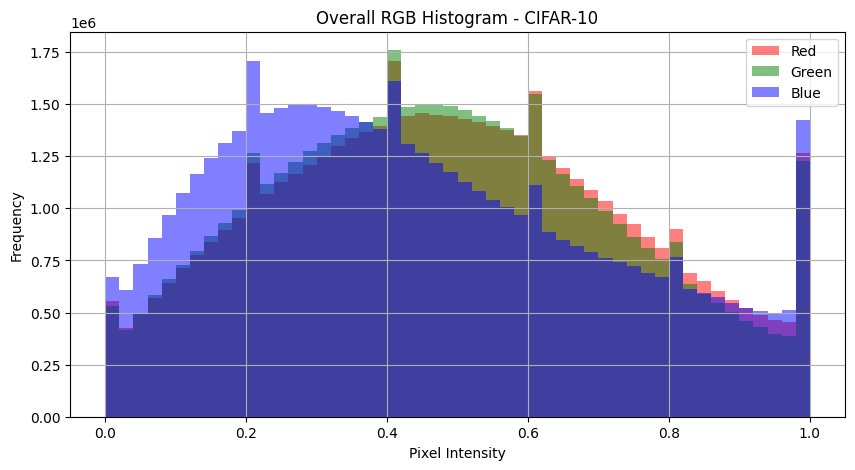

In [ ]:
def plot_rgb_histogram(images, title="RGB Channel Histogram"):
    r = images[:, :, :, 0].flatten()
    g = images[:, :, :, 1].flatten()
    b = images[:, :, :, 2].flatten()

    plt.figure(figsize=(10, 5))
    plt.hist(r, bins=50, alpha=0.5, color='red', label='Red')
    plt.hist(g, bins=50, alpha=0.5, color='green', label='Green')
    plt.hist(b, bins=50, alpha=0.5, color='blue', label='Blue')
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot overall histogram
plot_rgb_histogram(x_train, "Overall RGB Histogram - CIFAR-10")

Looking at the histogram, we can see how pixel intensities are distributed across the red, green, and blue channels in the CIFAR-10 dataset. The x-axis represents the intensity value of each pixel, ranging from 0 (completely dark) to 1 (completely bright), while the y-axis shows how frequently each intensity occurs across all images.

We notice that all three channels follow a somewhat similar distribution pattern, but with some subtle differences. The blue channel has a slightly higher frequency of lower intensity values compared to red and green, meaning that blue tones tend to be more dominant in the dataset. This could indicate that the images in CIFAR-10 contain more objects or backgrounds with blue colors, such as skies, water, or vehicles.

The red and green channels have very similar shapes but differ slightly in their peak positions and magnitudes. Red appears to have a broader spread toward higher intensities than green, suggesting that red tones are more varied in brightness across the dataset. Green tends to cluster more tightly around mid-range intensities.

All three channels show a general trend of increasing frequency from 0 up to a peak around 0.3–0.4, after which the frequency gradually decreases. This indicates that most pixels in the dataset fall within the mid-brightness range, with fewer very dark or very bright pixels. There is no sharp peak near zero, so it’s unlikely that many images are overly dark or underexposed. Similarly, the drop-off at high intensities suggests that there are relatively few overexposed regions.

This kind of distribution gives us insight into how models trained on CIFAR-10 might behave. Since most pixels are in the mid-range, models may become biased toward learning features in this range and might struggle slightly with very bright or very dark inputs unless proper normalization or augmentation techniques are applied. The dominance of the blue channel also suggests that color-based feature extraction could benefit from adjusting for this imbalance, either through preprocessing or model-level adjustments.

If you've applied data augmentation like brightness or contrast changes, comparing this histogram to one made from augmented images would help ensure that the transformations maintain realistic color distributions and don't distort the data too much.

# **Confusion Matrix**

In [ ]:
# Get predicted probabilities for test set
y_pred = loaded_model.predict(x_test)

# Convert predictions from probabilities to class labels (0 to 9)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoding to class labels
y_true_classes = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step


In [ ]:
# Compute the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

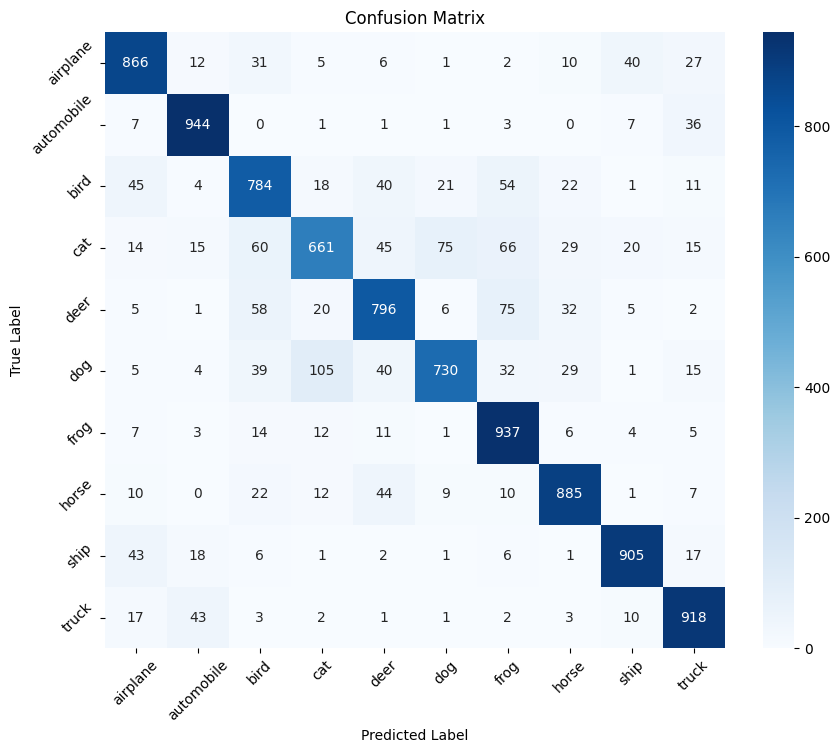

In [ ]:
# Plot the Confusion Matrix Using Seaborn
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

From the confusion matrix, We can see that most classes are being classified correctly, especially frog, horse, ship, and truck, which all have over 900 correct predictions each. That gives us confidence that the model has learned meaningful features from the data.

However, We've also noticed some interesting patterns in the misclassifications. It seems like the model tends to confuse similar-looking classes — especially vehicles like airplanes, automobiles, ships, and trucks. For example, airplanes are sometimes mistaken for ships or trucks, and automobiles are often confused with trucks. This makes sense because these objects share common visual characteristics like wheels, metallic surfaces, or aerodynamic shapes.

Similarly, We also noticed quite a few mix-ups between animal classes — birds are often predicted as airplanes or dogs, cats get confused with frogs or deer, and frogs themselves are frequently mistaken for deer. These results suggest that the model might be struggling to capture subtle differences between animals that look similar or appear in overlapping environments.

Despite these misclassifications, the model doesn’t seem to be overfitting or underfitting too badly since the validation performance aligns well with training. Still, We believe there’s room for improvement. We can explore transfer learning using pre-trained models like ResNet or EfficientNet to extract better features, especially for distinguishing those tricky subclasses.

# **Visual Inspection of images the model got wrong**

313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 145ms/step


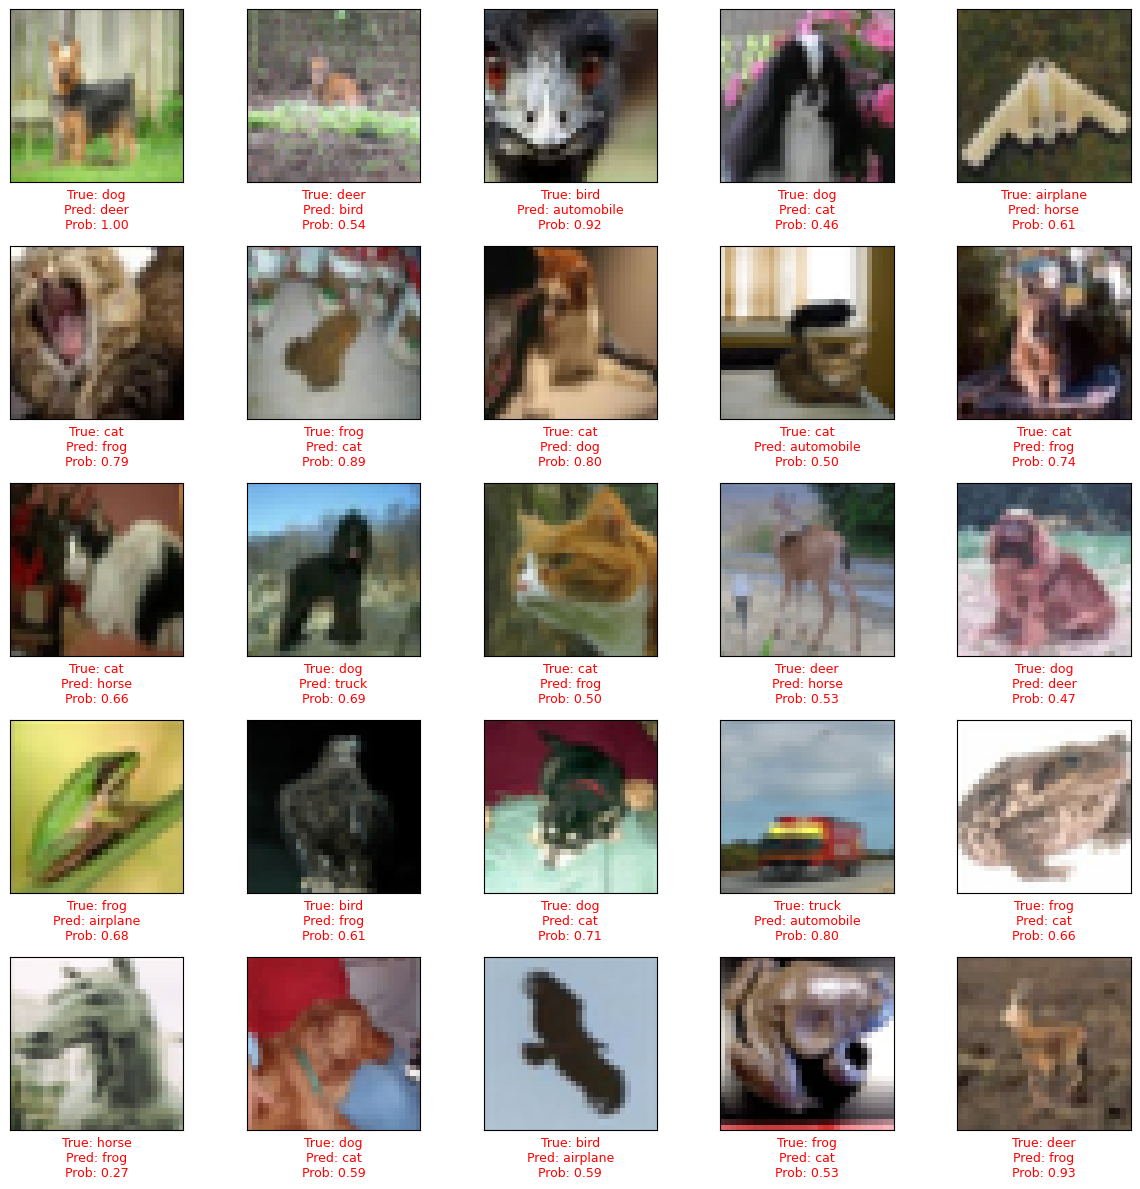

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

# Get predictions
y_pred_probs = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Find incorrect predictions
incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]

# Choose how many misclassified images to show
num_images = min(25, len(incorrect_indices))  # Show up to 25
sample_indices = incorrect_indices[:num_images]

# Plot them in a grid with confidence added
plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[idx])  # No cmap needed for RGB images

    predicted_label = y_pred_classes[idx]
    true_label = y_true_classes[idx]
    confidence = y_pred_probs[idx][predicted_label]

    # Add title with true/predicted label and confidence
    title = f"True: {class_names[true_label]}\n"
    title += f"Pred: {class_names[predicted_label]}\n"
    title += f"Prob: {confidence:.2f}"

    plt.xlabel(title, fontsize=9, color='red')
plt.tight_layout()
plt.show()

Visual inspection of misclassified images involves looking at the actual images your model got wrong during prediction. This helps you understand why errors occurred and how to improve the model. You start by comparing predicted labels with true labels on a test set, identify which predictions were incorrect, and then display those images visually in a grid format. Each image is shown with its true label, predicted label, and optionally, the model's confidence score for that prediction.

This process reveals patterns such as confusion between similar classes (like cat vs dog or bird vs airplane), ambiguous or low-quality images, or even possible label errors in the dataset. It also helps identify if the model is overconfident when it's wrong, which may indicate overfitting or poor generalization.

By analyzing these mistakes visually, you gain insights into model weaknesses and can make informed decisions about improving data quality, adjusting data augmentation strategies, or modifying the model architecture. It’s a powerful step after training to debug and refine your model’s performance beyond just numerical metrics like accuracy or loss.

# **Classification Report**

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(classification_report(y_true_classes, y_pred_classes,
                            target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.85      0.87      0.86      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.77      0.78      0.78      1000
         cat       0.79      0.66      0.72      1000
        deer       0.81      0.80      0.80      1000
         dog       0.86      0.73      0.79      1000
        frog       0.79      0.94      0.86      1000
       horse       0.87      0.89      0.88      1000
        ship       0.91      0.91      0.91      1000
       truck       0.87      0.92      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



# **Bar Charts**

<ipython-input-9-92aeb0dcbacf>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=precision, palette="Blues_d")
<ipython-input-9-92aeb0dcbacf>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=recall, palette="Greens_d")
<ipython-input-9-92aeb0dcbacf>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=per_class_accuracy, palette="Purples_d")


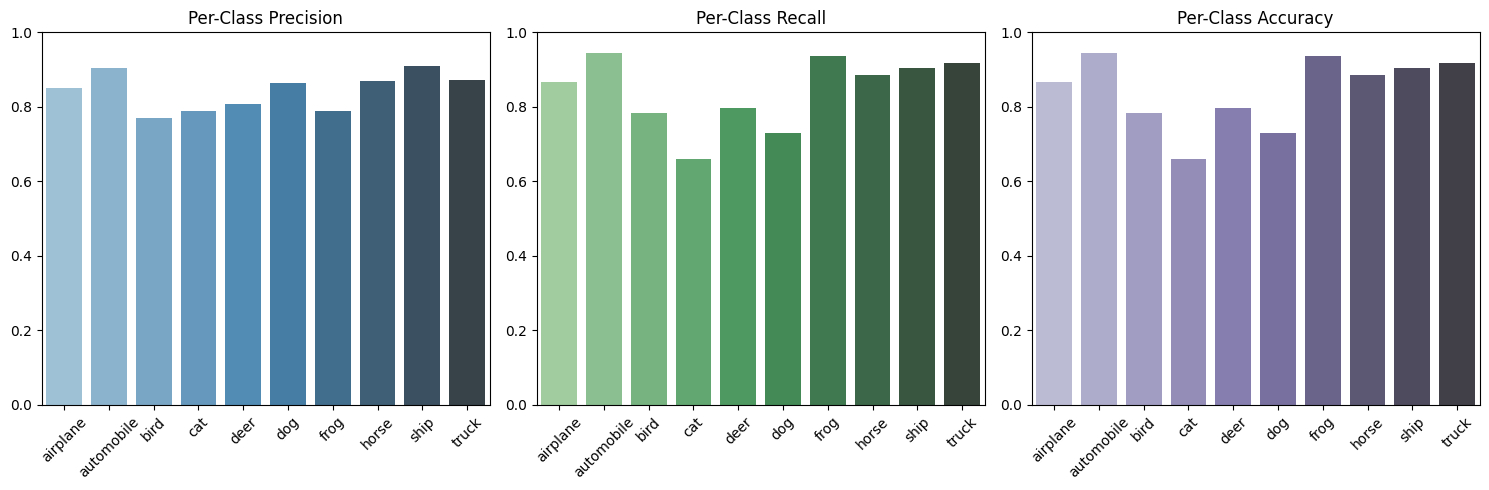

In [ ]:
# Compute per-class precision and recall
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
accuracy = accuracy_score(y_true_classes, y_pred_classes, )

# Optional: compute per-class accuracy manually
per_class_accuracy = []
for i in range(len(class_names)):
    mask = (y_true_classes == i)
    acc = (y_pred_classes[mask] == y_true_classes[mask]).mean()
    per_class_accuracy.append(acc)

# Plotting
plt.figure(figsize=(15, 5))

# Precision
plt.subplot(1, 3, 1)
sns.barplot(x=class_names, y=precision, palette="Blues_d")
plt.xticks(rotation=45)
plt.title('Per-Class Precision')
plt.ylim([0,1])

# Recall
plt.subplot(1, 3, 2)
sns.barplot(x=class_names, y=recall, palette="Greens_d")
plt.xticks(rotation=45)
plt.title('Per-Class Recall')
plt.ylim([0,1])

# Accuracy
plt.subplot(1, 3, 3)
sns.barplot(x=class_names, y=per_class_accuracy, palette="Purples_d")
plt.xticks(rotation=45)
plt.title('Per-Class Accuracy')
plt.ylim([0,1])

plt.tight_layout()
plt.show()

Looking at the classification report, the model shows **generally solid performance** across most classes with an overall accuracy of 84%. Starting with the stronger performers, we can see that classes like automobile, ship, and truck have some of the highest precision, recall, and F1-scores, all above 0.90, indicating that the model is both confident and effective in identifying these objects. This could be due to the distinct shapes and consistent features of vehicles like ships and trucks, which are easier for the model to learn and distinguish from other categories.

Moving on to other classes, airplane and horse also perform quite well with balanced precision and recall values, hovering around 0.85–0.90. These results suggest that the model captures the key visual patterns associated with these categories effectively. Frog stands out with a very high recall of 0.94, meaning it rarely misses a frog when it’s present in the image, although its precision is slightly lower, implying there may be occasional false positives where the model incorrectly identifies something else as a frog.

However, not all classes perform equally well. The cat class shows a noticeable drop in recall (0.66), meaning the model struggles to identify cats consistently, even though when it does predict a cat, it's usually correct (precision is 0.79). This suggests that the model may benefit from additional **training data** or **augmentation** strategies specific to this class, as it might be more visually ambiguous or varied in appearance compared to others. Similarly, dog has decent precision but a lower recall (0.73), indicating missed opportunities where the model fails to detect actual dogs in the test set.

Bird performs moderately with precision and recall values around 0.77, suggesting room for improvement in both confidence and detection. Deer shows relatively balanced metrics, with precision and recall values close to 0.80, indicating consistent performance without major issues in either direction.

The macro average and weighted average scores both sit around 0.84, aligning closely with the overall accuracy, which confirms that the model generalizes well across all classes without strong bias toward any particular one. Since CIFAR-10 is a balanced dataset, the similarity between macro and weighted averages makes sense and indicates fair performance distribution.

In summary, while the model is performing well overall, certain animal classes such as cat and dog appear to be more challenging for the model to recognize consistently. Improving the model further could involve targeted techniques such as enhancing data diversity through advanced augmentations, analyzing misclassified samples for insight into failure cases, or experimenting with deeper architectures that can capture more complex features.

In [ ]:
def plot_filters(model, layer_name, grid_size=(8, 8), normalize=True):
    # Get the desired layer
    layer = model.get_layer(name=layer_name)
    weights = layer.get_weights()[0]  # [filter_height, filter_width, in_channels, out_channels]

    print(f"Visualizing filters from layer '{layer_name}' with shape: {weights.shape}")

    num_filters = weights.shape[-1]
    filter_height = weights.shape[0]
    filter_width = weights.shape[1]
    num_channels = weights.shape[2]

    # Normalize filter values to [0, 1] for visualization
    if normalize:
        w_min, w_max = np.min(weights), np.max(weights)
        weights = (weights - w_min) / (w_max - w_min)

    # Prepare figure
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    fig.suptitle(f"Filters from Layer '{layer_name}'", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            # Get the i-th filter
            filt = weights[:, :, :, i]

            # For RGB input (3 channels), display as image
            if num_channels == 3:
                ax.imshow(filt)
            else:
                ax.imshow(filt[:, :, 0], cmap='gray')

            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

Visualizing filters from layer 'conv2d' with shape: (3, 3, 3, 64)


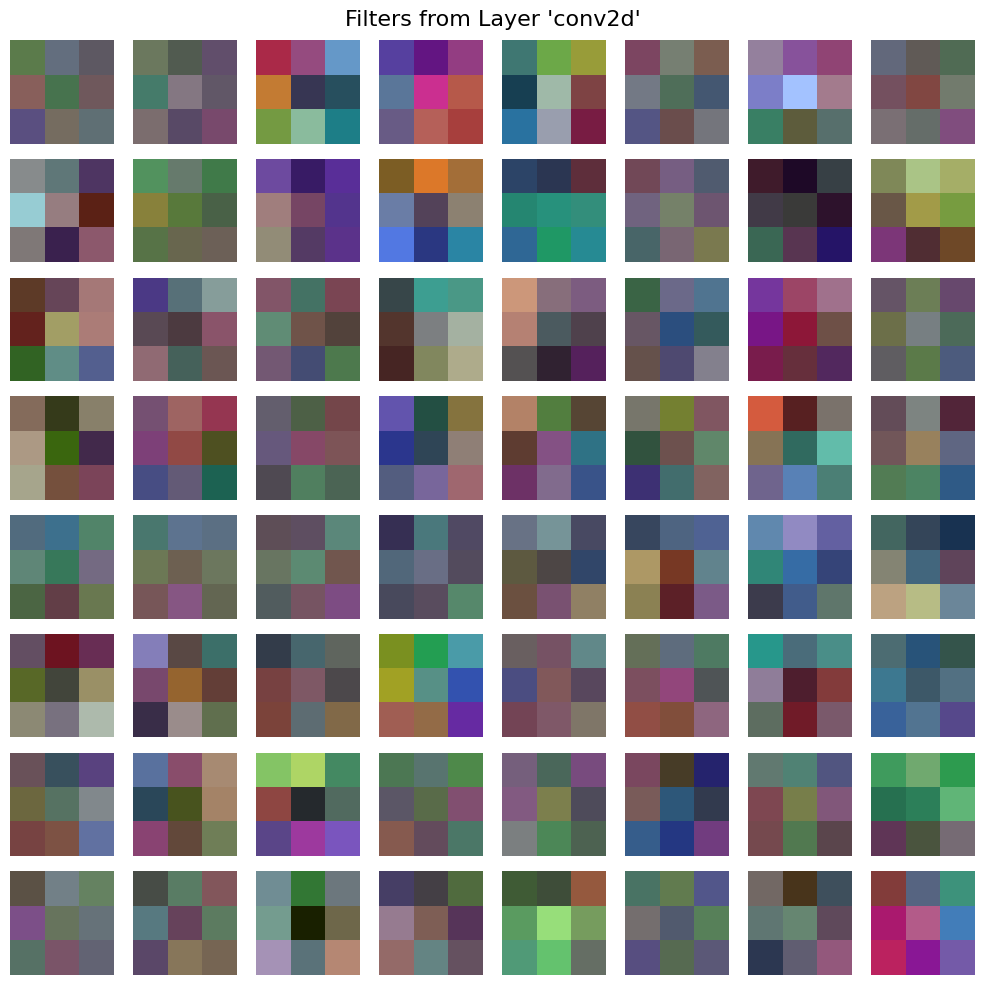

In [ ]:
plot_filters(loaded_model, layer_name='conv2d', grid_size=(8, 8))

Visualizing filters from layer 'conv2d_3' with shape: (3, 3, 128, 128)


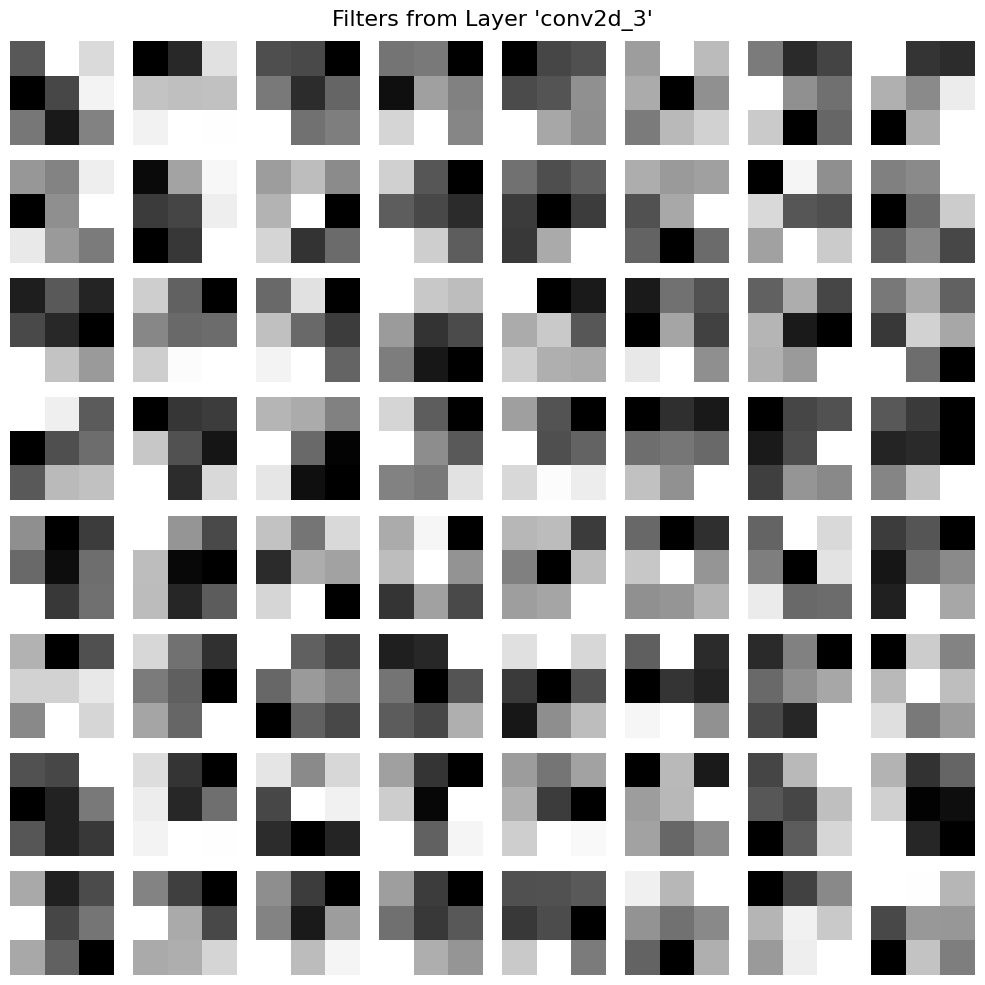

In [ ]:
plot_filters(loaded_model, layer_name='conv2d_3', grid_size=(8, 8))